# Importing required packages
* tesnsorflow, numpy, pandas
* cv2 for drawing rectangle on images
* tdqm for showing progress bar
* shutil for copying images

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random

from tqdm.auto import tqdm
import shutil as sh
from PIL import Image

In [2]:
train_dir = "/kaggle/input/car-object-detection/data/training_images/"
test_dir = "/kaggle/input/car-object-detection/data/testing_images/"

print('Image(train): ', len(os.listdir(train_dir)))
print('Image(test): ', len(os.listdir(test_dir)))

Image(train):  1001
Image(test):  175


In [3]:
data = pd.read_csv("/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv")

In [4]:
data.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [5]:
print(data.shape)
data.nunique()

(559, 5)


image    355
xmin     440
ymin     149
xmax     438
ymax     184
dtype: int64

(380, 676, 3)
Name,xmin,ymin,xmax,ymax: image    vid_4_2020.jpg
xmin         273.921852
ymin         196.816281
xmax         370.283647
ymax         232.517696
Name: 222, dtype: object
(380, 676, 3)
Name,xmin,ymin,xmax,ymax: image    vid_4_6380.jpg
xmin         525.342981
ymin         184.100708
xmax         599.693198
ymax         217.845882
Name: 453, dtype: object
(380, 676, 3)
Name,xmin,ymin,xmax,ymax: image    vid_4_13720.jpg
xmin           38.153401
ymin          193.392857
xmax          180.984081
ymax          250.123874
Name: 81, dtype: object
(380, 676, 3)
Name,xmin,ymin,xmax,ymax: image    vid_4_26500.jpg
xmin          359.033285
ymin          183.611647
xmax          446.590449
ymax          228.605212
Name: 335, dtype: object


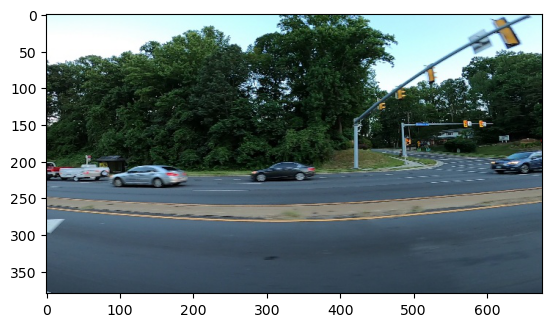

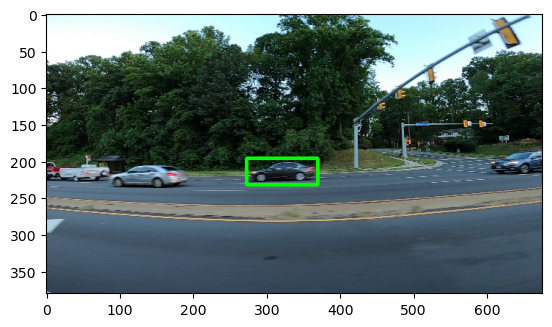

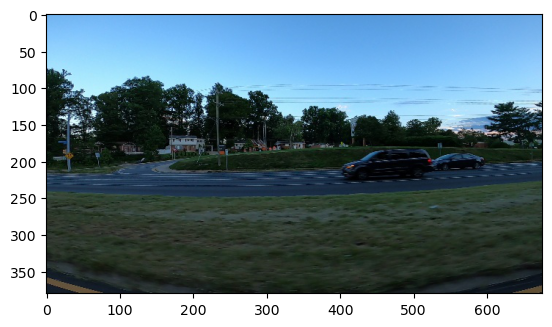

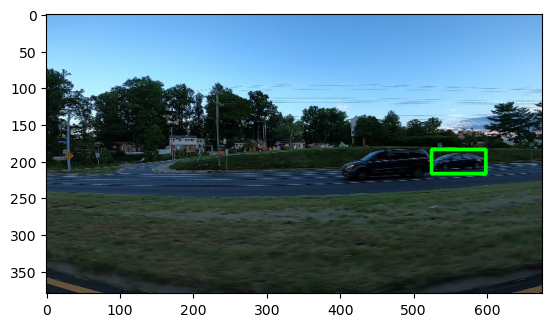

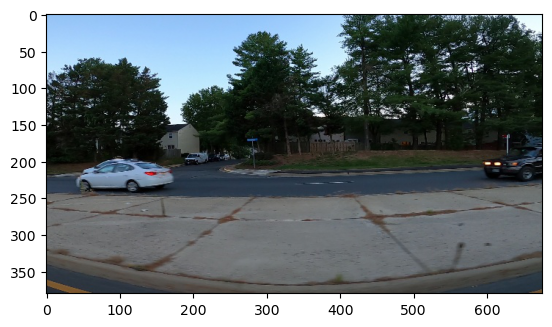

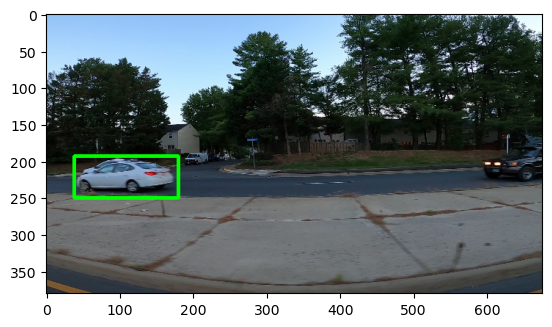

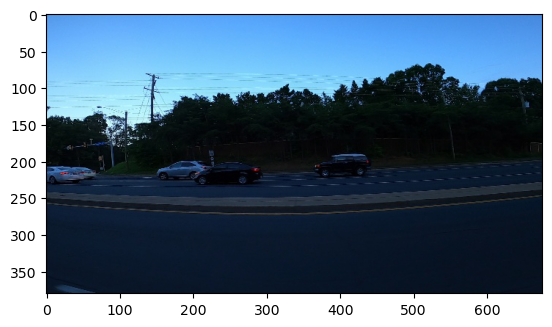

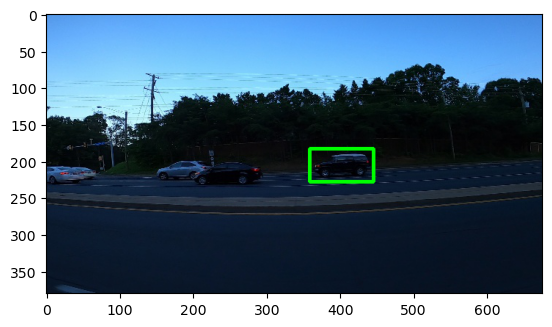

In [6]:
IMAGE_SHAPE = 0
for i in range(4):
    rand = np.random.randint(0, data.shape[0])
    random_row = data.iloc[rand]
    image = plt.imread(train_dir + random_row[0])
    plt.figure()
    plt.imshow(image)
    IMAGE_SHAPE = image.shape
    print(image.shape)
    print('Name,xmin,ymin,xmax,ymax:',random_row)
    point1 = (int(random_row[1]), int(random_row[2]))
    point2 = (int(random_row[3]), int(random_row[4]))
    cv2.rectangle(image, point1, point2, color=(0, 255, 0), thickness=3)
    plt.figure()
    plt.imshow(image)

In [7]:
!git clone https://github.com/ultralytics/yolov5
!cd yolov5
!pip install -r ./yolov5/requirements.txt

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Cloning into 'yolov5'...
remote: Enumerating objects: 16000, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 16000 (delta 20), reused 20 (delta 12), pack-reused 15967
Receiving objects: 100% (16000/16000), 14.59 MiB | 27.52 MiB/s, done.
Resolving deltas: 100% (10986/10986), done.
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 6.6 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 1.22.0 Requires-Python >=3.8; 1.22.1 Requires-Python >=3.8; 1.22.2 Requires-Python >=3.8; 1.22.3 Requires-Python >=3.8; 1.22.4 Requires-Python >=3.8; 1.23.0 Requires-Python >=3.8; 1.23.0rc1 Requires

# Data processing

Converting (xmin,ymin,xmax,ymax) to (x_center,y_center, w, h) as yolo5 required that format.

In [8]:
im_h, im_w, num_chanels = IMAGE_SHAPE
data["x_center"] = (data["xmax"] + data["xmin"])/2
data["y_center"] = (data["ymax"] + data["ymin"])/2
data["w"] = data["xmax"] - data["xmin"]
data["h"] = data["ymax"] - data["ymin"]
data["classes"] = 0
#Normalizing the values with image height and width
data["x_center"] = data["x_center"]/im_w
data["w"] = data["w"]/im_w
data["y_center"] = data["y_center"]/im_h
data["h"] = data["h"]/im_h
data.head()

image        xmin        ymin        xmax        ymax  x_center  \
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547  0.450434   
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180  0.100217   
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180  0.444645   
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575  0.833213   
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422  0.110347   

   y_center         w         h  classes  
0  0.539817  0.068741  0.095238        0  
1  0.557191  0.155572  0.129987        0  
2  0.543678  0.181621  0.157014        0  
3  0.531451  0.197540  0.155727        0  
4  0.559122  0.171491  0.136422        0

In [9]:
index = list(data.image)
print(len(index))

559


In [10]:
if not os.path.exists("data"):
    os.makedirs("data")
    os.makedirs("data/fold{}".format(0))

In [11]:
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(data.groupby('image')):
            if name in val_index:
                path2save = 'val/'
            else:
                path2save = 'train/'
            if not os.path.exists('data/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('data/fold{}/labels/'.format(fold)+path2save)
            with open('data/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('data/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('data/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/kaggle/input/car-object-detection/data/{}/{}".format(source,name),'data/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))
        print("Copy done")
        print('Image(train): ', len(os.listdir('data/fold0/images/train/')))
        print('Image(test): ', len(os.listdir('data/fold0/images/val/')))

  0%|          | 0/355 [00:00<?, ?it/s]

Copy done
Image(train):  281
Image(test):  74


In [12]:
%%writefile dataset.yaml
path: /kaggle/working/data/fold0
train: /kaggle/working/data/fold0/images/train/
val: /kaggle/working/data/fold0/images/val/
test:

names:
    0: car

Writing dataset.yaml


In [13]:
IMG_SIZE = IMAGE_SHAPE[1]
CONF_TRESHOLD = 0.6
IOU_THRESHOLD = 0.5
MODEL = 'yolov5x.pt'

In [14]:
import time

start = time.perf_counter()

!python yolov5/train.py --batch 12 --epochs 12 --data dataset.yaml --weights {MODEL} --name my_model_5x

end = time.perf_counter()

total_time = end - start

print(f'Training time for {MODEL} model is: {total_time:0.2f} seconds')

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.7/616.7 kB 15.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.9/614.9 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.4/614.4 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.9/606.9 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.2/606.2 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.5/605.5 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.6/605.6 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 17.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60
wandb: WARNING ⚠️ wandb is deprecated and will be 

In [15]:
!ls yolov5/runs/train/my_model_5x/

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
F1_curve.png					  results.png
PR_curve.png					  train_batch0.jpg
P_curve.png					  train_batch1.jpg
R_curve.png					  train_batch2.jpg
confusion_matrix.png				  val_batch0_labels.jpg
events.out.tfevents.1696269328.d8b7fb6c9a33.86.0  val_batch0_pred.jpg
hyp.yaml					  val_batch1_labels.jpg
labels.jpg					  val_batch1_pred.jpg
labels_correlogram.jpg				  val_batch2_labels.jpg
opt.yaml					  val_batch2_pred.jpg
results.csv					  weights


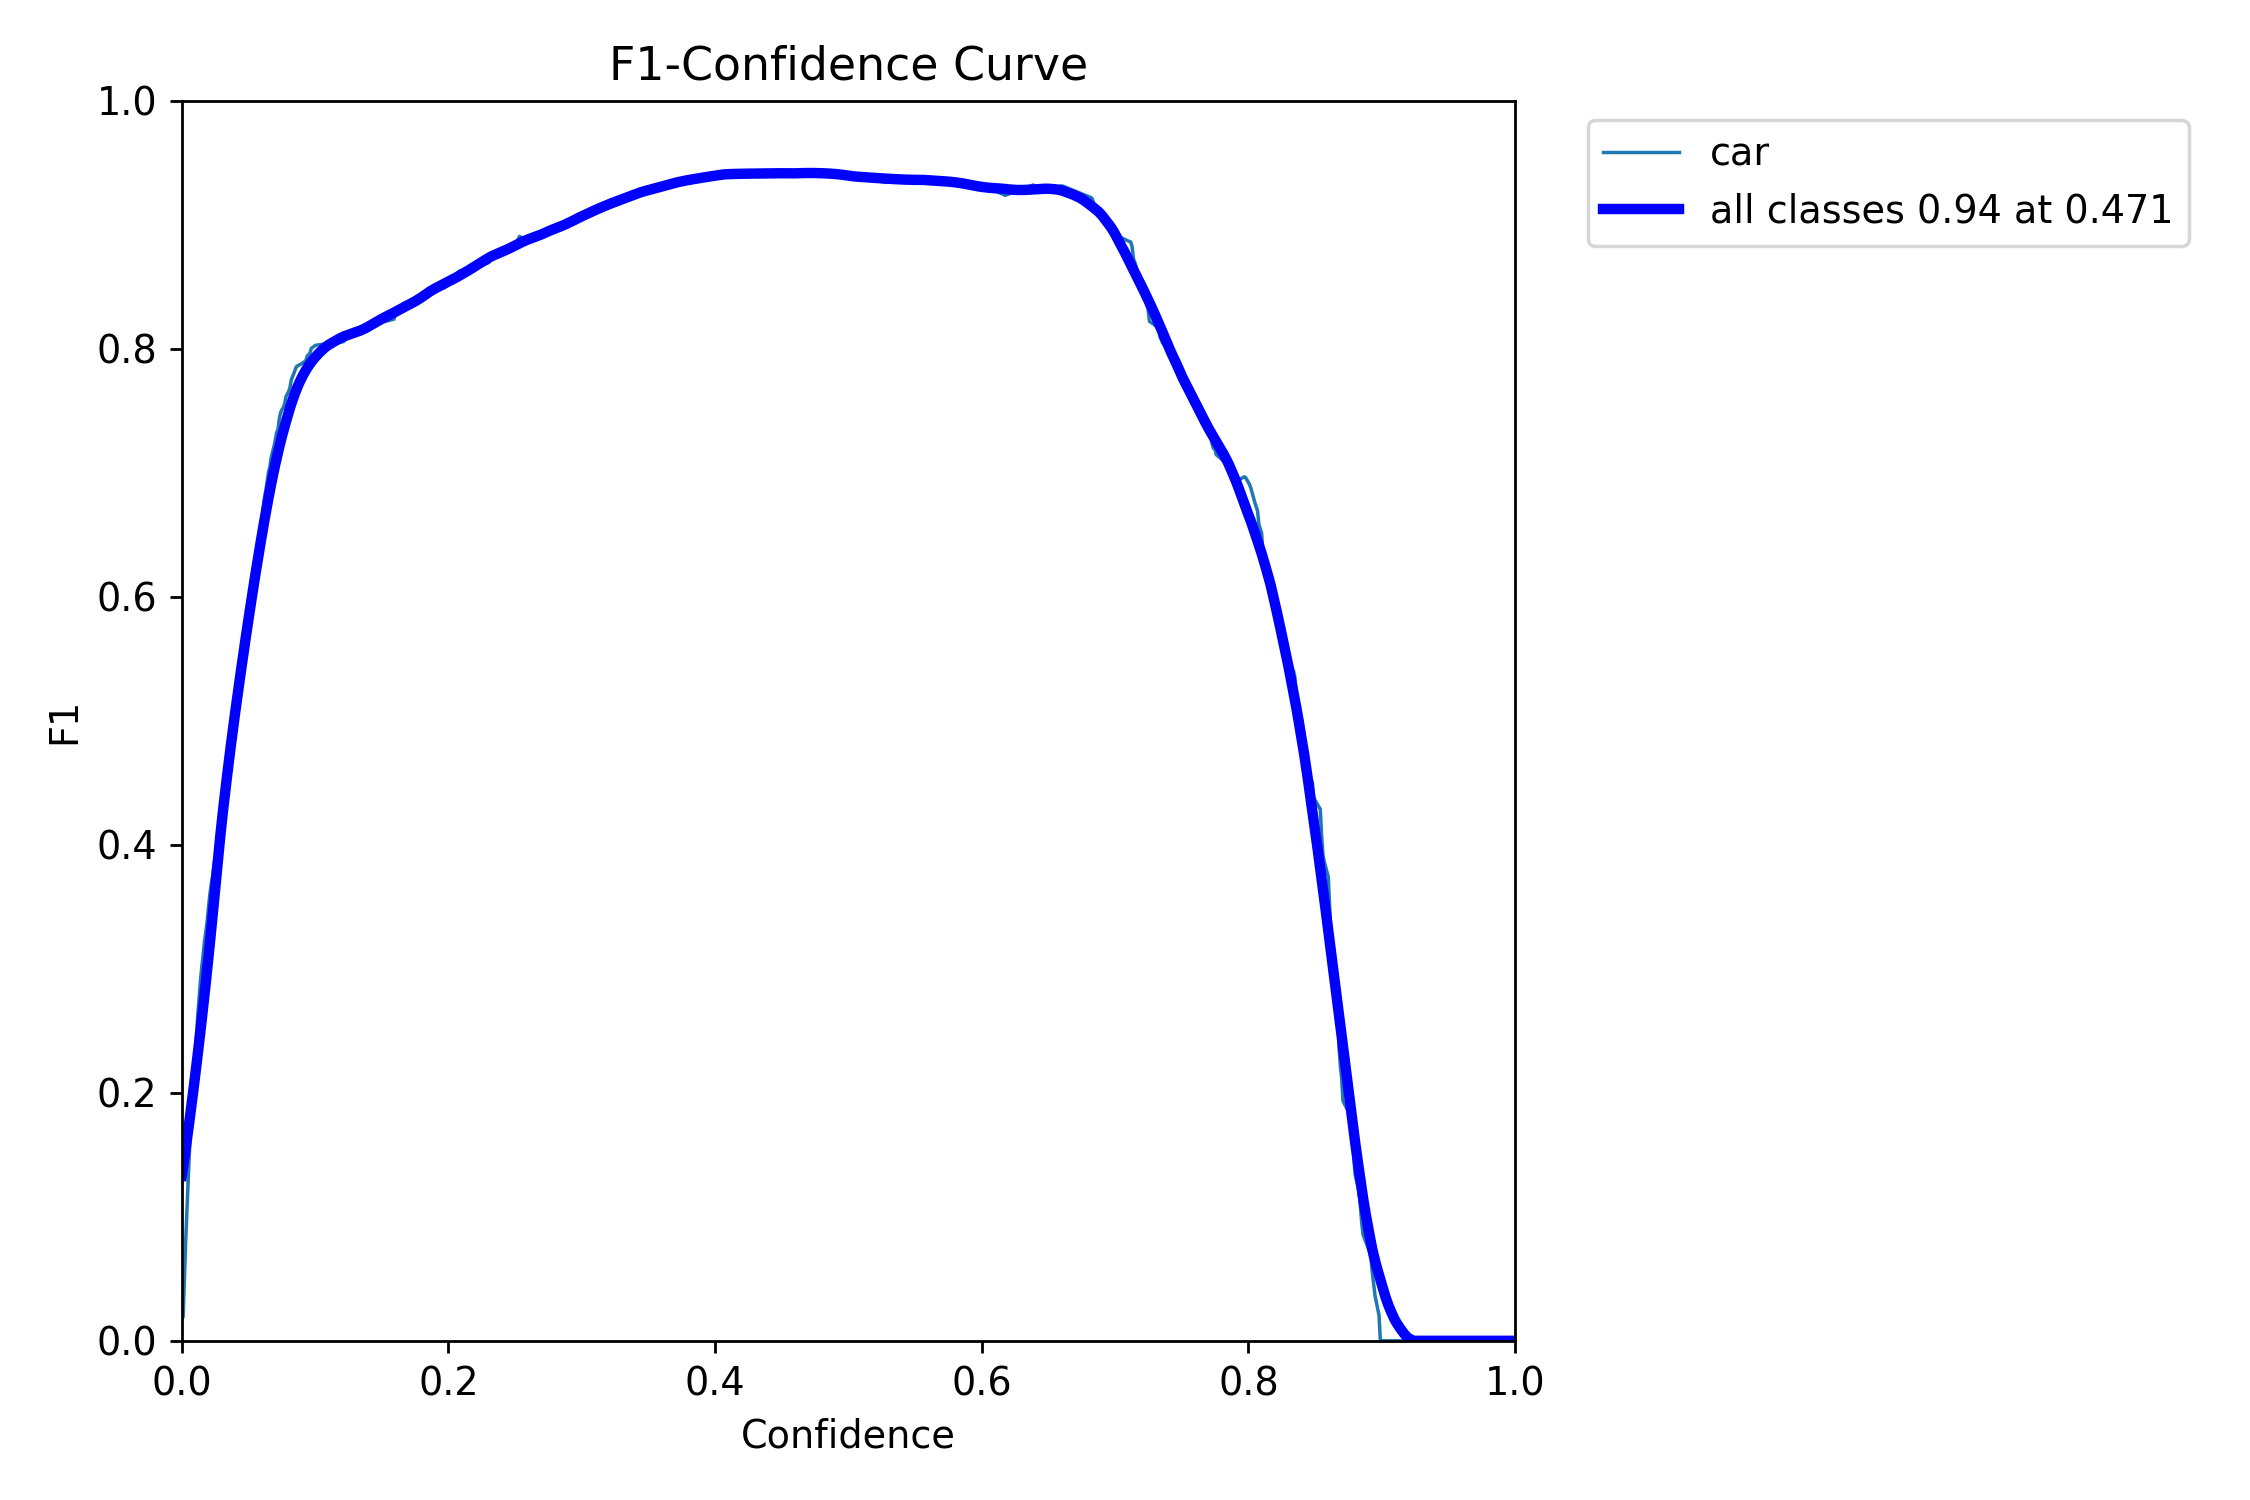

In [16]:
Image.open("yolov5/runs/train/my_model_5x/F1_curve.png")

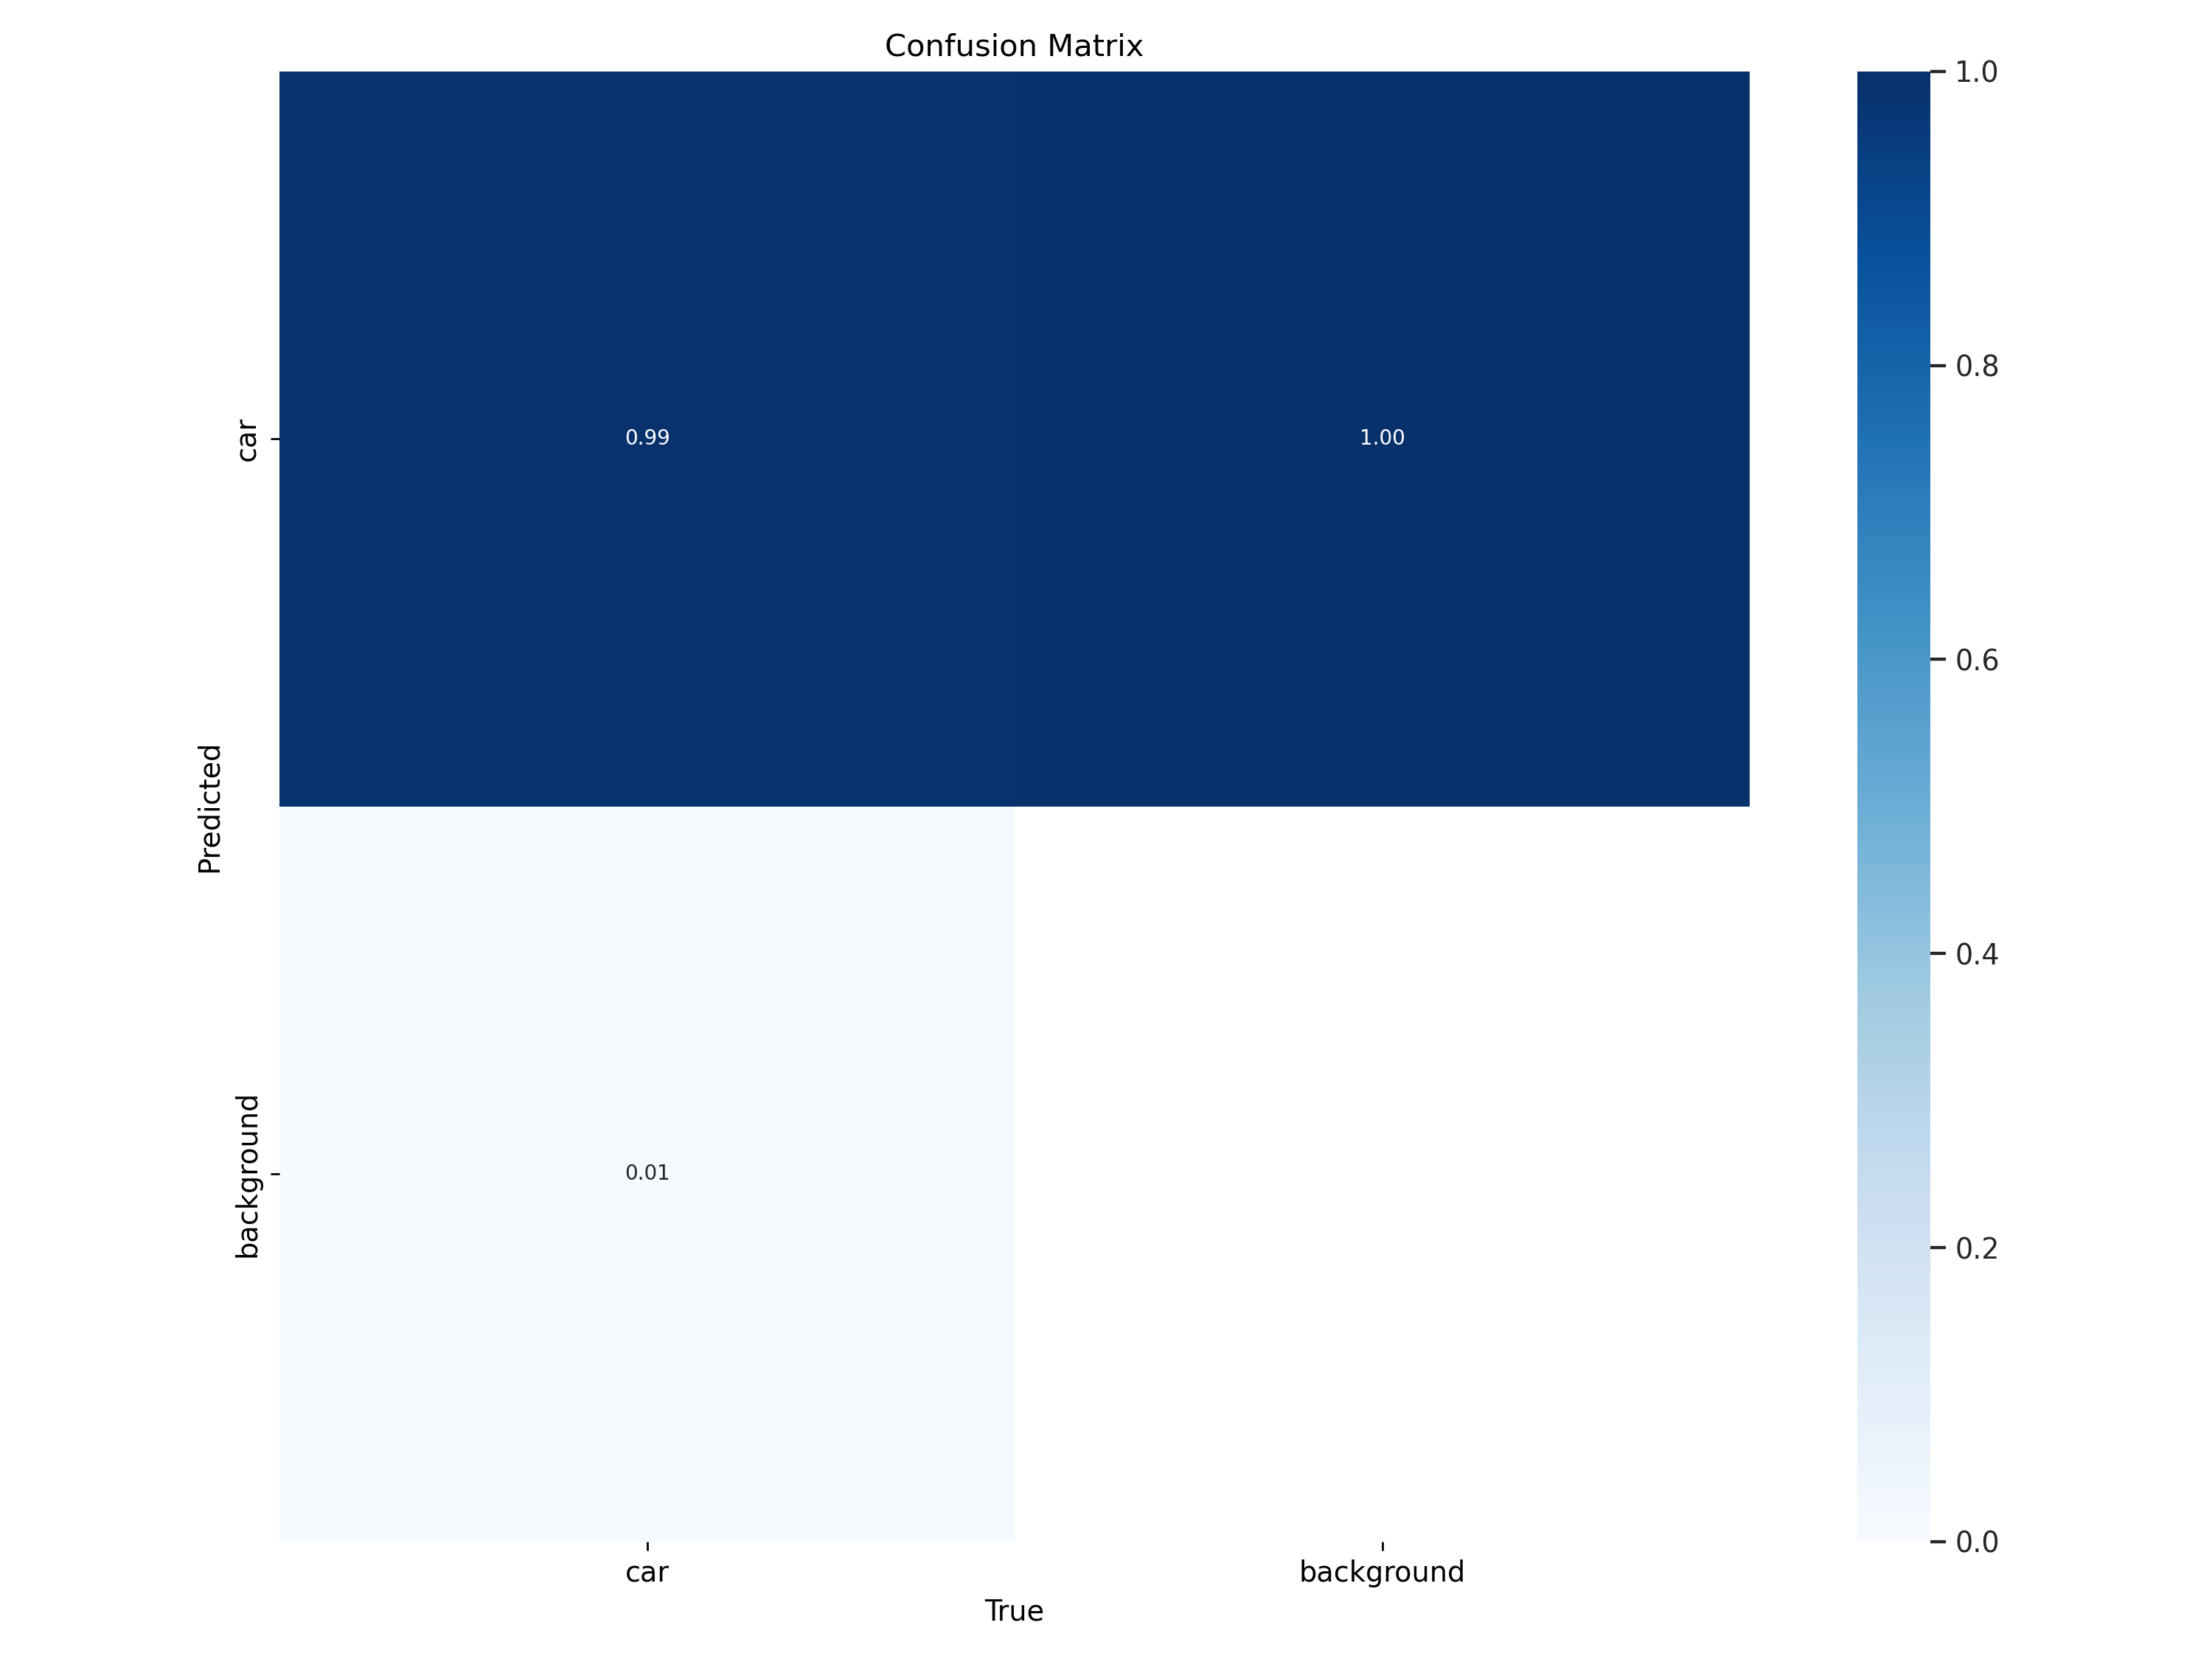

In [17]:
Image.open("yolov5/runs/train/my_model_5x/confusion_matrix.png")

# Detecting cars on test images

We are now going to use our custom trained model to detect cars on our testing images. The wieghts of our train model are inside "yolov5/runs/train/my_model_5x/weights/best.pt".

In [18]:
!python ./yolov5/detect.py --img {IMG_SIZE} --conf {CONF_TRESHOLD} --iou-thres {IOU_THRESHOLD} --source {test_dir} --weights yolov5/runs/train/my_model_5x/weights/best.pt

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
detect: weights=['yolov5/runs/train/my_model_5x/weights/best.pt'], source=/kaggle/input/car-object-detection/data/testing_images/, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.6, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-225-gbb9706e Python-3.7.12 torch-1.12.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 322 layers, 86173414 parameters, 0 gradients, 203.8 GFLOPs
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/175 /kaggle/input/car-object-detection/data/testing_images/vid

In [19]:
!ls yolov5/runs/detect/exp/

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
vid_5_25100.jpg  vid_5_27460.jpg  vid_5_28540.jpg  vid_5_30640.jpg
vid_5_25120.jpg  vid_5_27480.jpg  vid_5_28560.jpg  vid_5_30660.jpg
vid_5_25140.jpg  vid_5_27500.jpg  vid_5_28580.jpg  vid_5_30680.jpg
vid_5_25160.jpg  vid_5_27520.jpg  vid_5_28600.jpg  vid_5_30700.jpg
vid_5_25180.jpg  vid_5_27540.jpg  vid_5_28620.jpg  vid_5_30720.jpg
vid_5_25200.jpg  vid_5_27560.jpg  vid_5_28640.jpg  vid_5_30740.jpg
vid_5_25220.jpg  vid_5_27580.jpg  vid_5_28660.jpg  vid_5_30760.jpg
vid_5_25240.jpg  vid_5_27600.jpg  vid_5_28680.jpg  vid_5_30820.jpg
vid_5_25260.jpg  vid_5_27620.jpg  vid_5_28700.jpg  vid_5_30840.jpg
vid_5_26320.jpg  vid_5_27640.jpg  vid_5_29000.jpg  vid_5_30860.jpg
vid_5_26400.jpg  vid_5_27660.jpg  vid_5_29020.jpg  vid_5_30920.jpg
vid_5_26420.jpg  vid_5_27680.jpg  vid_5_29040.jpg  vid_5_30940.jpg
vid_5_26560.jpg  vid_5_27700.jpg  vid_5_29060.jpg  vid_5_31020.jpg
vid_5_26580.jpg  vid_5_27720.jp

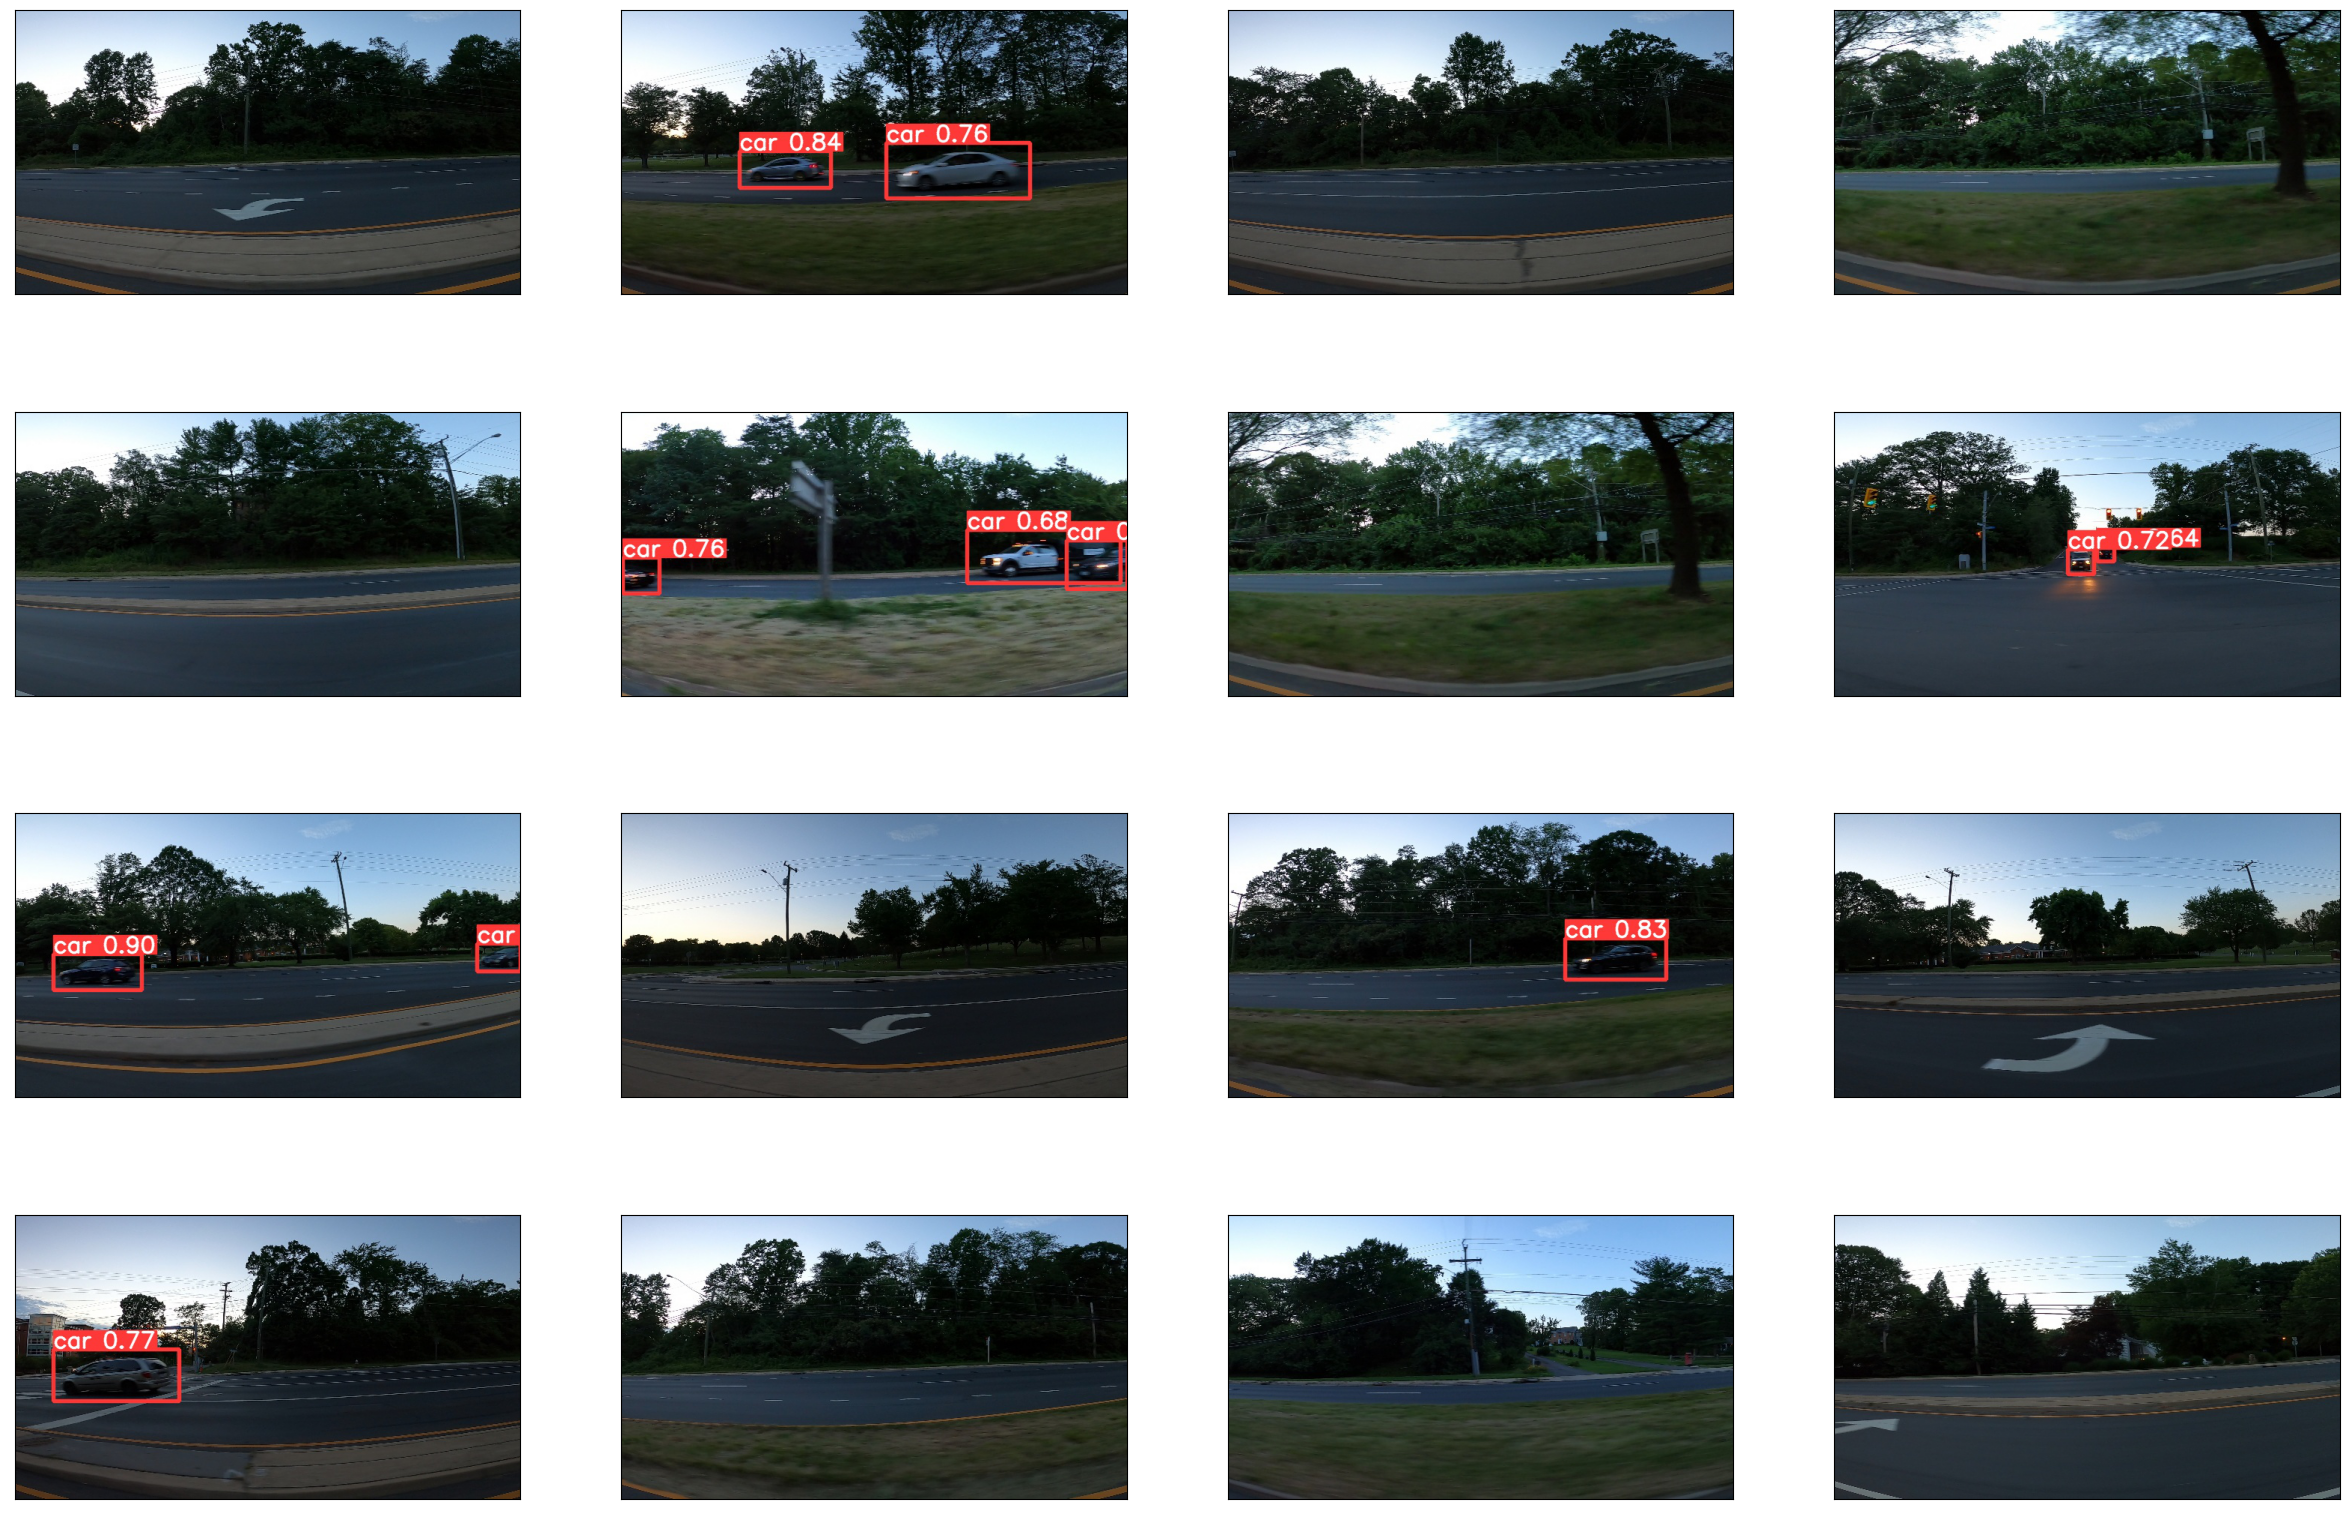

In [20]:
pred_dir = './yolov5/runs/detect/exp'
file_paths = []
flist = os.listdir(pred_dir)
for file in flist:
    fpath = os.path.join(pred_dir, file)
    file_paths.append(fpath)

plt.figure(figsize=(30, 20))
for i in range(16):
    random = np.random.randint(0, len(file_paths) - 1)
    plt.subplot(4, 4, i + 1)
    img_path = file_paths[random]
    img = plt.imread(img_path)
    plt.imshow(img)
    #plt.title('Predictions', size=10, color="black") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()